# MNIST

## Import

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

%cd /src
from nets import *
from utils import train, validate
%cd ..

/content/ChebyKAN
/content/efficient-kan/src
/content


## Data

In [ ]:
ds = "MNIST"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_dataset, valid_dataset = torch.utils.data.random_split(full_dataset, [0.8, 0.2])
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:10<00:00, 935464.65it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134751.53it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:06<00:00, 241861.57it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4909930.09it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(48000, 12000, 10000)

In [ ]:
train_images = full_dataset.data[train_dataset.indices]
valid_images = full_dataset.data[valid_dataset.indices]
test_images = test_dataset.data.clone()

In [ ]:
train_labels = full_dataset.targets[train_dataset.indices]
valid_labels = full_dataset.targets[valid_dataset.indices]
test_labels = test_dataset.targets.clone()

In [ ]:
len(train_labels), len(valid_labels), len(test_labels)

(48000, 12000, 10000)

In [ ]:
ds_dim= 28*28
no_classes = 10
model_type = "wide"

## ChebyKAN Model

In [ ]:
layers_details = [ds_dim, 2*ds_dim, no_classes]
poly_degree = 1
model_name = "ChebyKAN"

In [ ]:
ChebyKAN_model = ChebyKAN(in_dim=ds_dim, out_dim=no_classes, layers_details=layers_details, degree=poly_degree).to(device)
total_params = sum(p.numel() for p in ChebyKAN_model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 2489984


In [ ]:
for module in ChebyKAN_model.layers:
  if isinstance(module, ChebyKANLayer):
    print(module.inputdim, module.outdim)

784 1568
1568 10


### Training

In [ ]:
criterion = nn.CrossEntropyLoss()

# LBFGS is really slow
# optimizer = optim.LBFGS(model.parameters(), lr=0.01)
# Adam works with very low lr
# optimizer = optim.Adam(ChebyKAN_model.parameters(), lr=0.0002)
optimizer = optim.AdamW(ChebyKAN_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

cuda is availabe!


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "
 10%|█         | 1/10 [00:14<02:11, 14.59s/it]

Epoch 1, Train Loss: 0.5147, Valid Loss: 0.2654, Valid Acc: 0.92


 20%|██        | 2/10 [00:28<01:52, 14.05s/it]

Epoch 2, Train Loss: 0.2330, Valid Loss: 0.1876, Valid Acc: 0.94


 30%|███       | 3/10 [00:41<01:37, 13.88s/it]

Epoch 3, Train Loss: 0.1726, Valid Loss: 0.1888, Valid Acc: 0.94


 40%|████      | 4/10 [00:55<01:22, 13.83s/it]

Epoch 4, Train Loss: 0.1396, Valid Loss: 0.1356, Valid Acc: 0.96


 50%|█████     | 5/10 [01:09<01:09, 13.82s/it]

Epoch 5, Train Loss: 0.1137, Valid Loss: 0.1418, Valid Acc: 0.96


 60%|██████    | 6/10 [01:23<00:54, 13.74s/it]

Epoch 6, Train Loss: 0.0979, Valid Loss: 0.1122, Valid Acc: 0.97


 70%|███████   | 7/10 [01:36<00:41, 13.71s/it]

Epoch 7, Train Loss: 0.0819, Valid Loss: 0.0992, Valid Acc: 0.97


 80%|████████  | 8/10 [01:50<00:27, 13.72s/it]

Epoch 8, Train Loss: 0.0732, Valid Loss: 0.0878, Valid Acc: 0.97


 90%|█████████ | 9/10 [02:04<00:13, 13.71s/it]

Epoch 9, Train Loss: 0.0640, Valid Loss: 0.0898, Valid Acc: 0.97


100%|██████████| 10/10 [02:17<00:00, 13.78s/it]

Epoch 10, Train Loss: 0.0572, Valid Loss: 0.0891, Valid Acc: 0.97


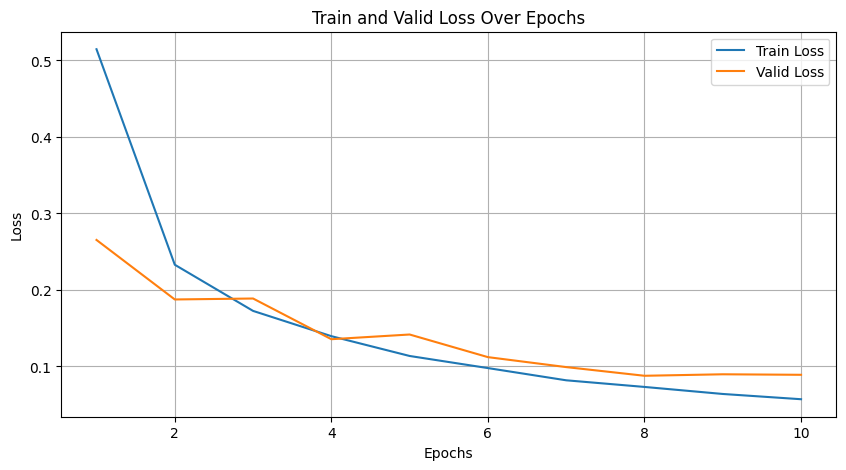

In [ ]:
train_losses = []
valid_losses = []

coeffs_dict = dict()

print(f"{device} is availabe!")

epochs = 10
for epoch in tqdm(range(epochs)):
    train_loss = train(ChebyKAN_model, train_loader, criterion, optimizer, device)
    valid_loss, valid_accuracy = validate(ChebyKAN_model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    scheduler.step()

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, '
          f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}')


plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Valid Loss')
plt.title('Train and Valid Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
ChebyKAN_test_loss, ChebyKAN_test_accuracy = validate(ChebyKAN_model, test_loader, criterion, device)

In [ ]:
ChebyKAN_test_loss, ChebyKAN_test_accuracy

(0.0856682926416397, 0.9746)

## EfficientKAN Model

In [ ]:
layers_details = [ds_dim, 2*ds_dim, no_classes]
poly_degree = 1
model_name = "EfficientKAN"

In [ ]:
EfficientKAN_model = EfficientKAN(layers_hidden=layers_details, spline_order=poly_degree).to(device)
total_params = sum(p.numel() for p in EfficientKAN_model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 9959936


In [ ]:
for module in EfficientKAN_model.layers:
  if isinstance(module, KANLinear):
    print(module.in_features, module.out_features)

784 1568
1568 10


### Training

In [ ]:
criterion = nn.CrossEntropyLoss()

# LBFGS is really slow
# optimizer = optim.LBFGS(model.parameters(), lr=0.01)
# Adam works with very low lr
# optimizer = optim.Adam(model.parameters(), lr=0.0002)
optimizer = optim.AdamW(EfficientKAN_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

cuda is availabe!


 10%|█         | 1/10 [00:16<02:29, 16.65s/it]

Epoch 1, Train Loss: 0.2025, Valid Loss: 0.1069, Valid Acc: 0.97


 20%|██        | 2/10 [00:33<02:12, 16.60s/it]

Epoch 2, Train Loss: 0.0624, Valid Loss: 0.0772, Valid Acc: 0.98


 30%|███       | 3/10 [00:49<01:55, 16.53s/it]

Epoch 3, Train Loss: 0.0305, Valid Loss: 0.0706, Valid Acc: 0.98


 40%|████      | 4/10 [01:06<01:39, 16.53s/it]

Epoch 4, Train Loss: 0.0129, Valid Loss: 0.0718, Valid Acc: 0.98


 50%|█████     | 5/10 [01:22<01:22, 16.51s/it]

Epoch 5, Train Loss: 0.0061, Valid Loss: 0.0684, Valid Acc: 0.98


 60%|██████    | 6/10 [01:39<01:05, 16.49s/it]

Epoch 6, Train Loss: 0.0029, Valid Loss: 0.0632, Valid Acc: 0.98


 70%|███████   | 7/10 [01:55<00:49, 16.47s/it]

Epoch 7, Train Loss: 0.0014, Valid Loss: 0.0646, Valid Acc: 0.98


 80%|████████  | 8/10 [02:12<00:32, 16.48s/it]

Epoch 8, Train Loss: 0.0007, Valid Loss: 0.0629, Valid Acc: 0.98


 90%|█████████ | 9/10 [02:28<00:16, 16.51s/it]

Epoch 9, Train Loss: 0.0004, Valid Loss: 0.0653, Valid Acc: 0.98


100%|██████████| 10/10 [02:45<00:00, 16.50s/it]

Epoch 10, Train Loss: 0.0003, Valid Loss: 0.0673, Valid Acc: 0.98


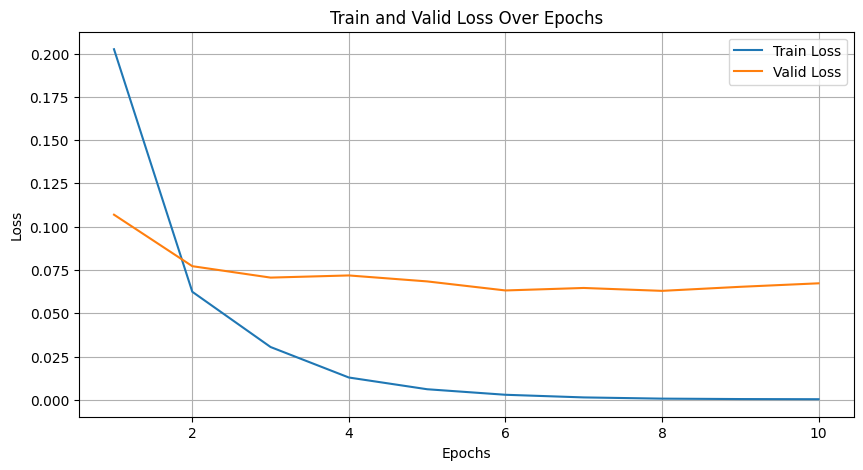

In [ ]:
train_losses = []
valid_losses = []

coeffs_dict = dict()

print(f"{device} is availabe!")

epochs = 10
for epoch in tqdm(range(epochs)):
    train_loss = train(EfficientKAN_model, train_loader, criterion, optimizer, device)
    valid_loss, valid_accuracy = validate(EfficientKAN_model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    scheduler.step()

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, '
          f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}')


plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Valid Loss')
plt.title('Train and Valid Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
EfficientKAN_test_loss, EfficientKAN_test_accuracy = validate(EfficientKAN_model, test_loader, criterion, device)

In [ ]:
EfficientKAN_test_loss, EfficientKAN_test_accuracy

(0.06052509695291519, 0.9847)

## NN Model

In [ ]:
layers_details = [ds_dim, 2*ds_dim, no_classes]
# poly_degree = 3
model_name = "FCN"

In [ ]:
FCN_model = FCN(in_dim=ds_dim, out_dim=no_classes, layers_details=layers_details).to(device)
total_params = sum(p.numel() for p in FCN_model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 1246570


In [ ]:
for module in FCN_model.layers:
  if isinstance(module, nn.Linear):
    print(module.in_features, module.out_features)

### Training

In [ ]:
criterion = nn.CrossEntropyLoss()

# LBFGS is really slow
# optimizer = optim.LBFGS(model.parameters(), lr=0.01)
# Adam works with very low lr
# optimizer = optim.Adam(model.parameters(), lr=0.0002)
optimizer = optim.AdamW(FCN_model.parameters(), lr=1e-3, weight_decay=1e-4)
# optimizer = optim.SGD(FCN_model.parameters(), lr=0.01, weight_decay=1e-6, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

cuda is availabe!


 10%|█         | 1/10 [00:12<01:56, 12.97s/it]

Epoch 1, Train Loss: 0.2034, Valid Loss: 0.1144, Valid Acc: 0.97


 20%|██        | 2/10 [00:25<01:43, 12.91s/it]

Epoch 2, Train Loss: 0.0761, Valid Loss: 0.0839, Valid Acc: 0.98


 30%|███       | 3/10 [00:38<01:30, 12.93s/it]

Epoch 3, Train Loss: 0.0421, Valid Loss: 0.0778, Valid Acc: 0.98


 40%|████      | 4/10 [00:51<01:17, 12.92s/it]

Epoch 4, Train Loss: 0.0233, Valid Loss: 0.0741, Valid Acc: 0.98


 50%|█████     | 5/10 [01:04<01:04, 12.90s/it]

Epoch 5, Train Loss: 0.0128, Valid Loss: 0.0671, Valid Acc: 0.98


 60%|██████    | 6/10 [01:17<00:51, 12.86s/it]

Epoch 6, Train Loss: 0.0073, Valid Loss: 0.0611, Valid Acc: 0.98


 70%|███████   | 7/10 [01:30<00:38, 12.86s/it]

Epoch 7, Train Loss: 0.0033, Valid Loss: 0.0581, Valid Acc: 0.99


 80%|████████  | 8/10 [01:43<00:25, 12.87s/it]

Epoch 8, Train Loss: 0.0019, Valid Loss: 0.0585, Valid Acc: 0.99


 90%|█████████ | 9/10 [01:56<00:12, 12.90s/it]

Epoch 9, Train Loss: 0.0011, Valid Loss: 0.0595, Valid Acc: 0.98


100%|██████████| 10/10 [02:08<00:00, 12.90s/it]

Epoch 10, Train Loss: 0.0007, Valid Loss: 0.0605, Valid Acc: 0.99


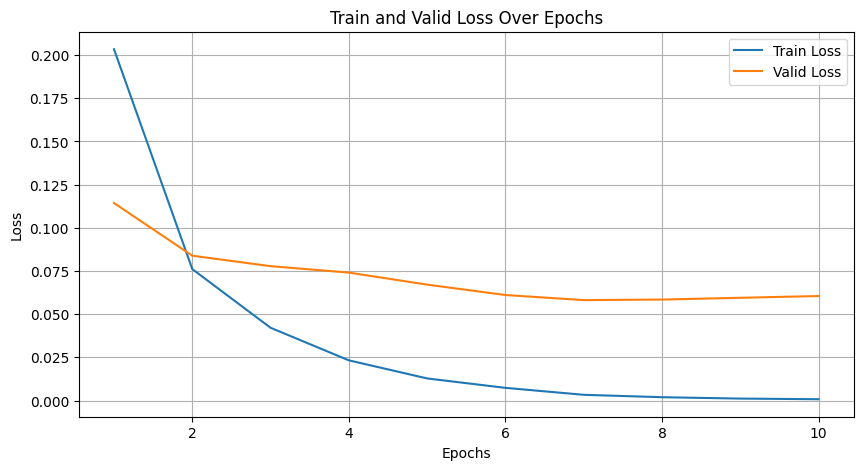

In [ ]:
train_losses = []
valid_losses = []

coeffs_dict = dict()

print(f"{device} is availabe!")

epochs = 10
for epoch in tqdm(range(epochs)):
    train_loss = train(FCN_model, train_loader, criterion, optimizer, device)
    valid_loss, valid_accuracy = validate(FCN_model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    scheduler.step()

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, '
          f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}')


plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Valid Loss')
plt.title('Train and Valid Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
FCN_test_loss, FCN_test_accuracy = validate(FCN_model, test_loader, criterion, device)

In [ ]:
FCN_test_loss, FCN_test_accuracy

(0.058655174588784574, 0.9849)